# Bank Account Fraud Detection

Name: Kristina Wu, Lin Zhou, Yishan Cai

## Set Up

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import missingno as msno
from imblearn.over_sampling import SMOTE


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.utils import shuffle

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier

In [2]:
df_1 = pd.read_csv('chunk_1.csv')
df_2 = pd.read_csv('chunk_2.csv')
df_3 = pd.read_csv('chunk_3.csv')
df_4 = pd.read_csv('chunk_4.csv')
df_5 = pd.read_csv('chunk_5.csv')

# do not delete content below, for reference!

• income (numeric): Annual income of the applicant (in decile form). Ranges between [0.1,0.9].

• name_email_similarity (numeric): Metric of similarity between email and applicant’s name. Higher values represent higher similarity. Ranges between [0,1].

• prev_address_months_count (numeric): Number of months in previous registered
address of the applicant, i.e. the applicant’s previous residence, if applicable. Ranges
between [−1,380] months (-1 is a missing value).

• current_address_months_count (numeric): Months in currently registered address of
the applicant. Ranges between [−1,429] months (-1 is a missing value).

• customer_age (numeric): Applicant’s age in years, rounded to the decade. Ranges
between [10,90] years.
under 18 is not allowed

• days_since_request (numeric): Number of days passed since application was done.
Ranges between [0,79] days.
long time, more suspicious

• intended_balcon_amount (numeric): Initial transferred amount for application.
Ranges between [−16,114] (negatives are missing values).
connect with income, inconsist -> fraud

• payment_type (categorical): Credit payment plan type. 5 possible (annonymized) values.

• zip_count_4w (numeric): Number of applications within same zip code in last 4 weeks. Ranges between [1,6830].
too condense might have some problems

• velocity_6h (numeric): Velocity of total applications made in last 6 hours i.e., average
number of applications per hour in the last 6 hours. Ranges between [−175,16818].
• velocity_24h(numeric): Velocityoftotalapplicationsmadeinlast24hoursi.e., average
number of applications per hour in the last 24 hours. Ranges between [1297,9586]
• velocity_4w (numeric): Velocity of total applications made in last 4 weeks, i.e., average
number of applications per hour in the last 4 weeks. Ranges between [2825,7020].


• bank_branch_count_8w (numeric): Number of total applications in the selected bank
branch in last 8 weeks. Ranges between [0,2404].
• date_of_birth_distinct_emails_4w (numeric): Number of emails for applicants with
same date of birth in last 4 weeks. Ranges between [0,39].

• employment_status (categorical): Employment status of the applicant. 7 possible (annonymized) values.
consist with income and intended_balcon_amount

• credit_risk_score (numeric): Internal score of application risk. Ranges between [−191,389].
high value, more risk

• email_is_free (binary): Domain of application email (either free or paid).

• housing_status (categorical): Current residential status for applicant. 7 possible (annonymized) values.
consist with income

• phone_home_valid (binary): Validity of provided home phone.
• phone_mobile_valid (binary): Validity of provided mobile phone.

• bank_months_count (numeric): How old is previous account (if held) in months. Ranges between [−1,32] months (-1 is a missing value).
small value, suspicious

• has_other_cards (binary): If applicant has other cards from the same banking company.
suspicious if many

• proposed_credit_limit (numeric): Applicant’s proposed credit limit. Ranges between[200,2000].
higher limit, more suspicious

• foreign_request (binary): If origin country of request is different from bank’s country.
suspicious if yes

• source (categorical): Online source of application. Either browser (INTERNET) or app (TELEAPP).
internet would be safe for fraudler

• session_length_in_minutes (numeric): Length of user session in banking website in
minutes. Ranges between [−1,107] minutes (-1 is a missing value).
shorter, more suspicious

• device_os (categorical): Operative system of device that made request. Possible values are: Windows, macOS, Linux, X11, or other.

• keep_alive_session (binary): User option on session logout.
logout suspicious

• device_distinct_emails (numeric): Number of distinct emails in banking website from the used device in last 8 weeks. Ranges between [−1,2] emails (-1 is a missing value).
more, suspicious

• device_fraud_count (numeric): Number of fraudulent applications with used device. Ranges between [0,1].

• month (numeric): Month where the application was made. Ranges between [0,7].

• fraud_bool (binary): If the application is fraudulent or not.

Data Quick Overview

In [3]:
df = pd.concat([df_1, df_2, df_3, df_4, df_5], ignore_index=True)
df.head().T

0            1            2  \
fraud_bool                                   0            0            0   
income                                     0.3          0.8          0.8   
name_email_similarity                 0.986506     0.617426     0.996707   
prev_address_months_count                   -1           -1            9   
current_address_months_count                25           89           14   
customer_age                                40           20           40   
days_since_request                    0.006735     0.010095     0.012316   
intended_balcon_amount              102.453711    -0.849551    -1.490386   
payment_type                                AA           AD           AB   
zip_count_4w                              1059         1658         1095   
velocity_6h                       13096.035018  9223.283431  4471.472149   
velocity_24h                       7850.955007  5745.251481  5471.988958   
velocity_4w                        6742.080561  5941.664859  5992.555113   
bank_branch_count_8w                         5            3           15   
date_of_birth_distinct_emails_4w             5           18           11   
employment_status                           CB           CA           CA   
credit_risk_score                          163          154           89   
email_is_free                                1            1            1   
housing_status                              BC           BC           BC   
phone_home_valid                             0            1            0   
phone_mobile_valid                           1            1            1   
bank_months_count                            9            2           30   
has_other_cards                              0            0            0   
proposed_credit_limit                   1500.0       1500.0        200.0   
foreign_request                              0            0            0   
source                                INTERNET     INTERNET     INTERNET   
session_length_in_minutes            16.224843     3.363854    22.730559   
device_os                                linux        other      windows   
keep_alive_session                           1            1            0   
device_distinct_emails_8w                    1            1            1   
device_fraud_count                           0            0            0   
month                                        0            0            0   

                                             3            4  
fraud_bool                                   0            0  
income                                     0.6          0.9  
name_email_similarity                   0.4751     0.842307  
prev_address_months_count                   11           -1  
current_address_months_count                14           29  
customer_age                                30           40  
days_since_request                    0.006991     5.742626  
intended_balcon_amount               -1.863101    47.152498  
payment_type                                AB           AA  
zip_count_4w                              3483         2339  
velocity_6h                       14431.993621  7601.511579  
velocity_24h                       6755.344479   5124.04693  
velocity_4w                        5970.336831  5940.734212  
bank_branch_count_8w                        11            1  
date_of_birth_distinct_emails_4w            13            6  
employment_status                           CA           CA  
credit_risk_score                           90           91  
email_is_free                                1            0  
housing_status                              BC           BC  
phone_home_valid                             0            1  
phone_mobile_valid                           1            1  
bank_months_count                            1           26  
has_other_cards                              0            0  
proposed_credit_limit                    200.0  

In [4]:
df.shape

(1000000, 32)

In [5]:
df.columns

Index(['fraud_bool', 'income', 'name_email_similarity',
       'prev_address_months_count', 'current_address_months_count',
       'customer_age', 'days_since_request', 'intended_balcon_amount',
       'payment_type', 'zip_count_4w', 'velocity_6h', 'velocity_24h',
       'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'employment_status',
       'credit_risk_score', 'email_is_free', 'housing_status',
       'phone_home_valid', 'phone_mobile_valid', 'bank_months_count',
       'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'source',
       'session_length_in_minutes', 'device_os', 'keep_alive_session',
       'device_distinct_emails_8w', 'device_fraud_count', 'month'],
      dtype='object')

## Exploring Data

### Data Basic Statistics

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 32 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   fraud_bool                        1000000 non-null  int64  
 1   income                            1000000 non-null  float64
 2   name_email_similarity             1000000 non-null  float64
 3   prev_address_months_count         1000000 non-null  int64  
 4   current_address_months_count      1000000 non-null  int64  
 5   customer_age                      1000000 non-null  int64  
 6   days_since_request                1000000 non-null  float64
 7   intended_balcon_amount            1000000 non-null  float64
 8   payment_type                      1000000 non-null  object 
 9   zip_count_4w                      1000000 non-null  int64  
 10  velocity_6h                       1000000 non-null  float64
 11  velocity_24h                      1000

In [7]:
df.describe()

fraud_bool          income  name_email_similarity  \
count  1000000.000000  1000000.000000         1000000.000000   
mean         0.011029        0.562696               0.493694   
std          0.104438        0.290343               0.289125   
min          0.000000        0.100000               0.000001   
25%          0.000000        0.300000               0.225216   
50%          0.000000        0.600000               0.492153   
75%          0.000000        0.800000               0.755567   
max          1.000000        0.900000               0.999999   

       prev_address_months_count  current_address_months_count  \
count             1000000.000000                1000000.000000   
mean                   16.718568                     86.587867   
std                    44.046230                     88.406599   
min                    -1.000000                     -1.000000   
25%                    -1.000000                     19.000000   
50%                    -1.000000                     52.000000   
75%                    12.000000                    130.000000   
max                   383.000000                    428.000000   

         customer_age  days_since_request  intended_balcon_amount  \
count  1000000.000000        1.000000e+06          1000000.000000   
mean        33.689080        1.025705e+00                8.661499   
std         12.025799        5.381835e+00               20.236155   
min         10.000000        4.036860e-09              -15.530555   
25%         20.000000        7.193246e-03               -1.181488   
50%         30.000000        1.517574e-02               -0.830507   
75%         40.000000        2.633069e-02                4.984176   
max         90.000000        7.845690e+01              112.956928   

         zip_count_4w     velocity_6h  ...  phone_mobile_valid  \
count  1000000.000000  1000000.000000  ...      1000000.000000   
mean      1572.692049     5665.296605  ...            0.889676   
std       1005.374565     3009.380665  ...            0.313293   
min          1.000000     -170.603072  ...            0.000000   
25%        894.000000     3436.365848  ...            1.000000   
50%       1263.000000     5319.769349  ...            1.000000   
75%       1944.000000     7680.717827  ...            1.000000   
max       6700.000000    16715.565404  ...            1.000000   

       bank_months_count  has_other_cards  proposed_credit_limit  \
count     1000000.000000   1000000.000000         1000000.000000   
mean           10.839303         0.222988             515.851010   
std            12.116875         0.416251             487.559902   
min            -1.000000         0.000000             190.000000   
25%            -1.000000         0.000000             200.000000   
50%             5.000000         0.000000             200.000000   
75%            25.000000         0.000000             500.000000   
max            32.000000         1.000000            2100.000000   

       foreign_request  session_length_in_minutes  keep_alive_session  \
count   1000000.000000             1000000.000000      1000000.000000   
mean          0.025242                   7.544940            0.576947   
std           0.156859                   8.033106            0.494044   
min           0.000000                  -1.000000            0.000000   
25%           0.000000                   3.103053            0.000000   
50%           0.000000                   5.114321            1.000000   
75%           0.000000                   8.866131            1.000000   
max           1.000000                  85.899143            1.000000   

       device_distinct_emails_8w  device_fraud_count           month  
count             1000000.000000           1000000.0  1000000.000000  
mean                    1.018312                 0.0        3.288674  
std                     0.180761                 0.0        2.209994  
min                    -1.000000                 0.0        0.00000

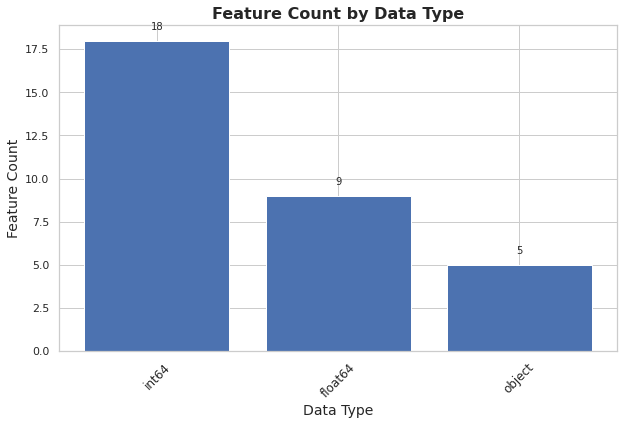

In [8]:
sns.set_theme(style="whitegrid")
data_types = df.dtypes.value_counts()
plt.figure(figsize=(10, 6))
bars = plt.bar(data_types.index.astype(str), data_types.values)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, yval, ha='center', va='bottom', fontsize=10)
plt.title('Feature Count by Data Type', fontsize=16, fontweight='bold')
plt.xlabel('Data Type', fontsize=14)
plt.ylabel('Feature Count', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.show()

#### Observation:
Upon reviewing the data type distribution in our dataset, it's apparent that integer-based numerical features predominate, comprising both int64 and float64 types. The int64 type is the most prevalent, suggesting a significant presence of features with discrete numerical values, which could include counts, identifiers, or binary variables, such as "fraud_bool", "credit_risk_score" and so on. The presence of float64 types indicates quantitative features that offer a spectrum of data, possibly representing measurements, probabilities, or other continuously varying quantities like income or velocity.<br>
Meanwhile, the object type typically encompasses categorical or textual data, representing a smaller portion of our features. These categorical features will require encoding to numerical values, as most machine learning models are designed to handle numerical input. This conversion is critical to enable the application of algorithms such as logistic regression and gradient boosting machines, which we aim to compare in our analysis. To facilitate this comparison and maintain model compatibility, we'll convert these object-type features into a numerical format through appropriate encoding techniques.

Checking Missing Value

<AxesSubplot:>

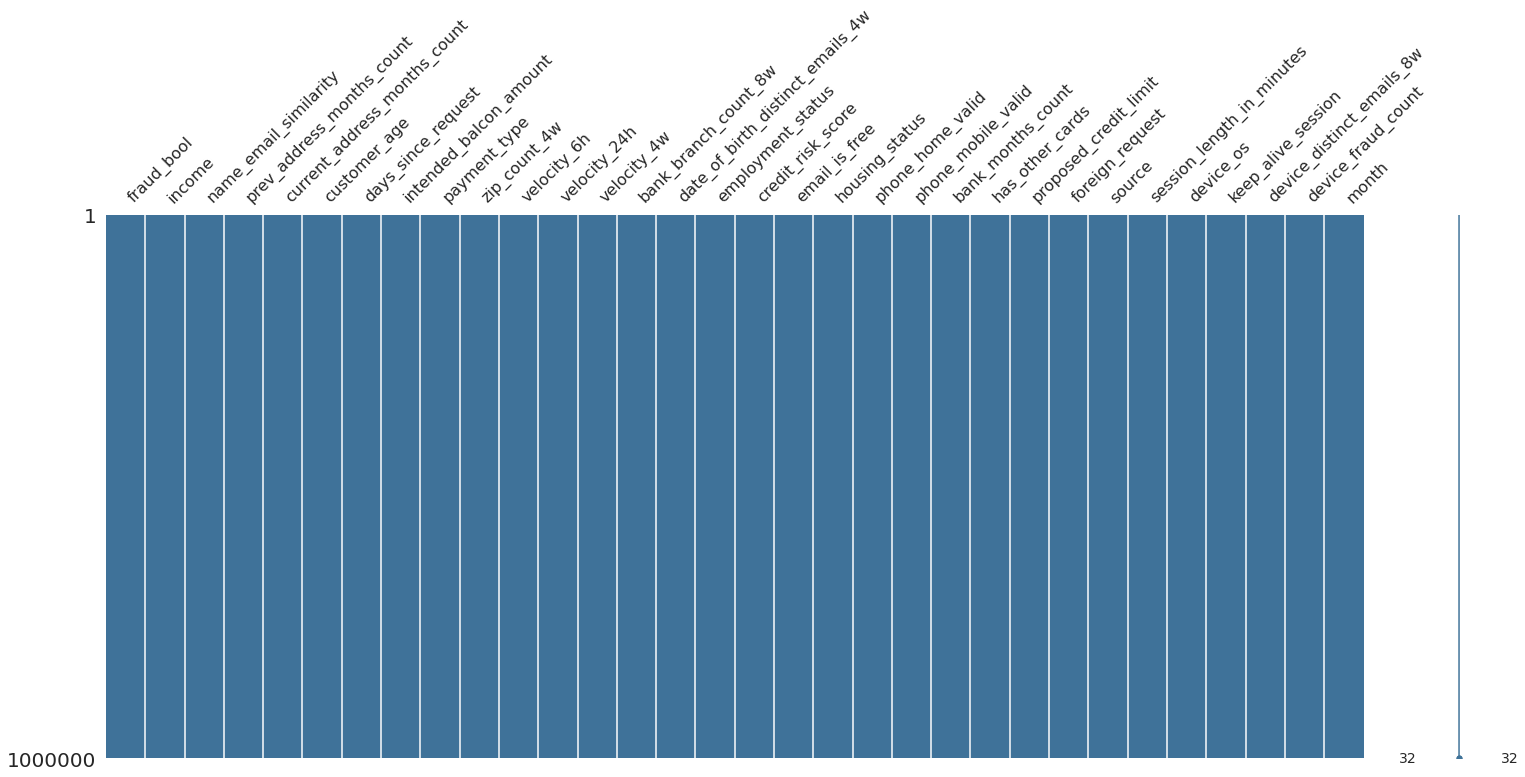

In [9]:
msno.matrix(df, color=(0.25, 0.45, 0.6))

Obviously, our dataset don't have any missing value. Great!!!

## Data Processing

### Random Sampling

In [10]:
half_df = df.sample(n=500000, replace=False).reset_index(drop = True)
half_df.head(3)

fraud_bool  income  name_email_similarity  prev_address_months_count  \
0           0     0.9               0.553003                        121   
1           0     0.2               0.914723                         -1   
2           0     0.6               0.639902                         -1   

   current_address_months_count  customer_age  days_since_request  \
0                            11            30            0.906262   
1                           149            40            0.017194   
2                            51            20            0.015186   

   intended_balcon_amount payment_type  zip_count_4w  ...  has_other_cards  \
0               -0.945176           AC           673  ...                0   
1               -1.133880           AB          2867  ...                0   
2               -0.879254           AB           985  ...                0   

   proposed_credit_limit  foreign_request    source  \
0                  500.0                0  INTERNET   
1                  200.0                0  INTERNET   
2                  200.0                0  INTERNET   

   session_length_in_minutes device_os  keep_alive_session  \
0                  10.223859     other                   1   
1                   3.802986     other                   1   
2                   5.073350     other                   1   

   device_distinct_emails_8w device_fraud_count  month  
0                          1                  0      7  
1                          1                  0      2  
2                          1                  0      5  

[3 rows x 32 columns]

In [11]:
half_df.shape

(500000, 32)

In the data preparation phase of our project, we have performed a random sampling on the extensive bank account fraud dataset originally consisting of 1,000,000 records, each with 32 features. To make our computational process more manageable and to enable quicker iterations during the exploratory data analysis and modeling phases, we've created a representative subset of this data by randomly selecting 50,000 records. This sampling approach preserves the underlying distribution of the data while reducing the volume to a size that is more practical for our analysis. By working with this sample, we aim to maintain the integrity and generalizability of our findings without the computational expense of handling the entire dataset.

### One-Hot Encoding

In [12]:
numerical_features = df.describe().T
num_df = half_df[numerical_features.index.to_list()]

In [13]:
def get_dummies(df, num_df):
    cate_list = ['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']
    
    for column in cate_list:
        dummies = pd.get_dummies(df[column])
        dummies = dummies.astype(int)
        num_df = pd.concat([num_df, dummies], axis=1)
        num_df = num_df.rename(columns={col: f'{column}_{col.lower()}' for col in dummies.columns})
    
    return num_df
    
new_df = get_dummies(half_df, num_df)

During data preprocessing, we conducted one-hot encoding to convert categorical variables into a numerical format suitable for machine learning algorithms. The process began by separating numerical features into a DataFrame, num_df. We defined a function, get_dummies, to process columns like 'payment_type', 'employment_status', 'housing_status', 'source', and 'device_os', generating a new column for each category within these features. Each category was encoded as a series of columns with integer values reflecting the presence of each category in the original data. This expanded num_df maintains clear labeling for interpretability and readies the dataset for machine learning applications.

### Checking Numerical Features Distribution

In [14]:
def visualize_numerical_features(df):
    numerical_features = df.select_dtypes(include=['int64', 'float64'])

    num_cols = len(numerical_features.columns)
    num_rows = (num_cols // 2) + (num_cols % 2)

    fig, axes = plt.subplots(num_rows, 2, figsize=(15, 4*num_rows))

    for i, feature in enumerate(numerical_features.columns):
        row = i // 2
        col = i % 2
        ax = axes[row, col]

        sns.histplot(data=df, x=feature, kde=True, ax=ax)
        ax.set_title(f"Distribution of {feature}")
        ax.set_xlabel(feature)
        ax.set_ylabel("Frequency")

    # Hide empty subplots if the number of features is odd
    if num_cols % 2 != 0:
        axes[-1, -1].axis("off")

    plt.tight_layout()
    plt.show()

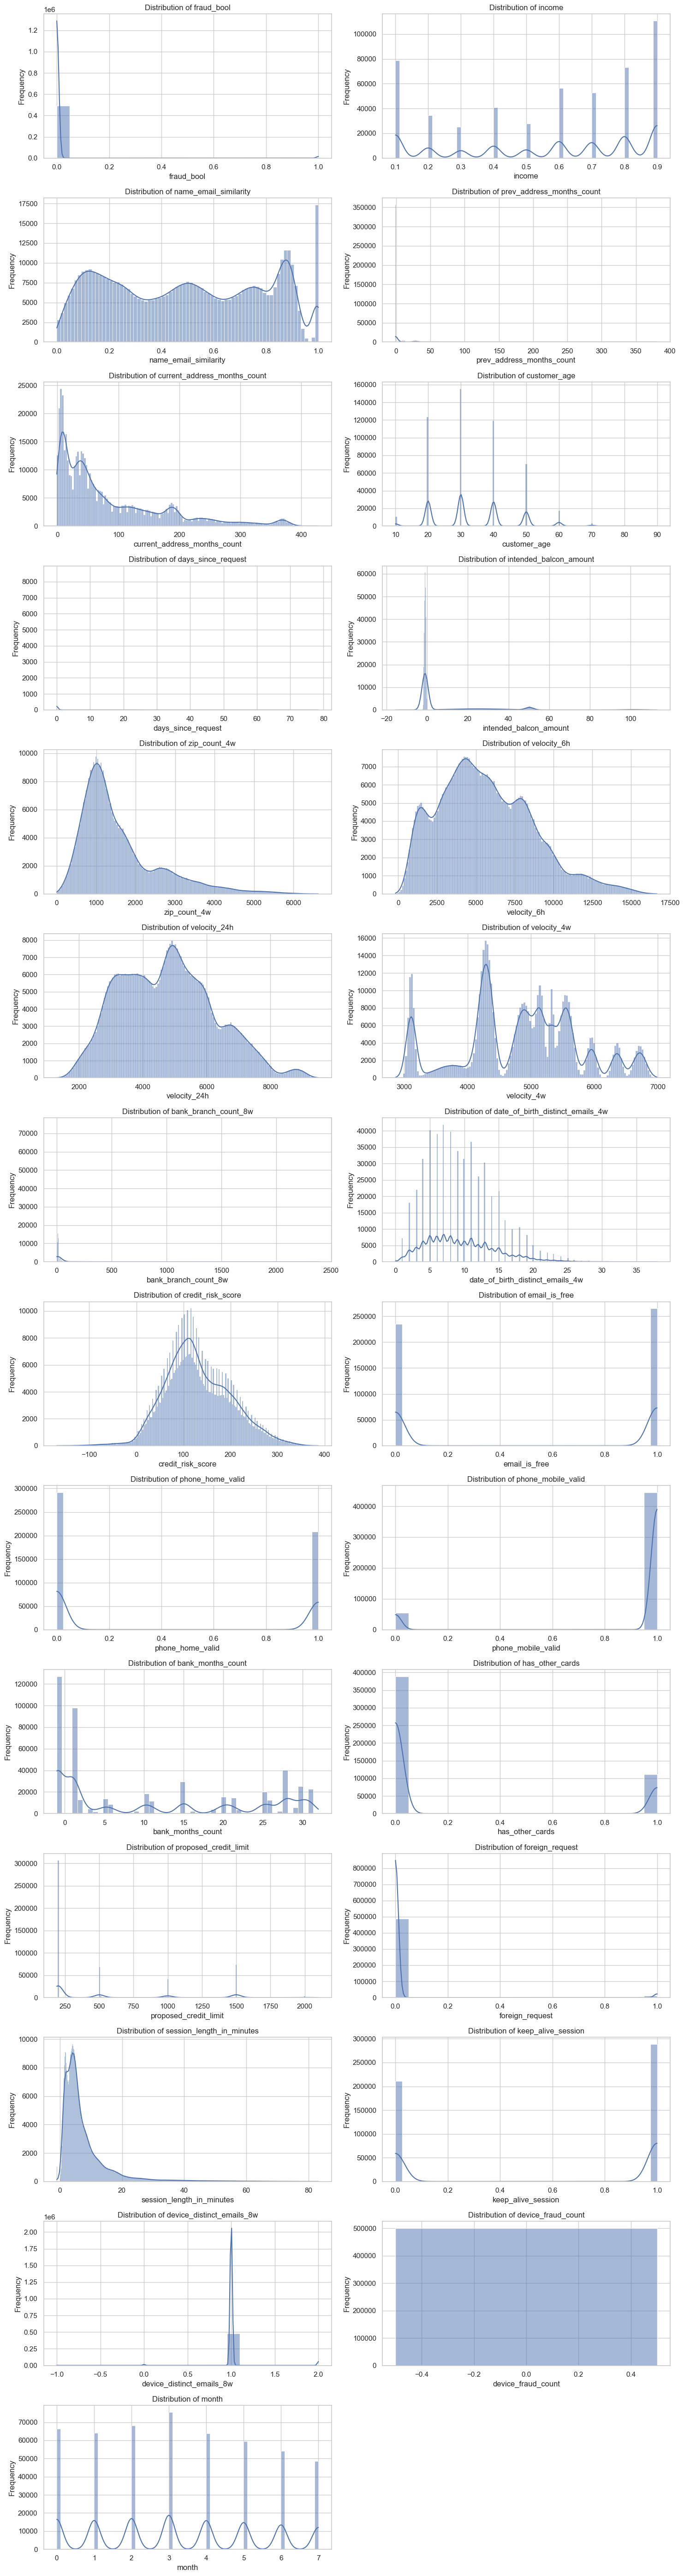

In [17]:
visualize_numerical_features(num_df)

After distribution analysis of the numerical features within our dataset through a series of histograms, we have identified evidence of skewness in several distributions. The histograms, which visually represent the frequency of observations, have shown that not all variables follow a normal distribution; some exhibit a pronounced tail to the right or left.

### Evaluate Skewness

In [15]:
skewness = (num_df.skew().to_frame().
            reset_index(names = ['features'])
            .rename(columns={0: 'skewness'})
            .sort_values(by = 'skewness')
            .reset_index(drop = True))

In [16]:
fig = px.bar(skewness, x='skewness', y='features', orientation='h',
             title='Skewness of Numerical Features',
             labels={'Skewness': 'Skewness', 'features': 'Features'})


fig.update_layout(width=800, height=1000)
fig.show()

In [17]:
skewness[(skewness['skewness'] > 1) | (skewness['skewness'] < -1)].reset_index()['features']

0               phone_mobile_valid
1            proposed_credit_limit
2                  has_other_cards
3     current_address_months_count
4                     zip_count_4w
5        device_distinct_emails_8w
6           intended_balcon_amount
7             bank_branch_count_8w
8        session_length_in_minutes
9        prev_address_months_count
10                 foreign_request
11              days_since_request
12                      fraud_bool
Name: features, dtype: object

#### Observation
In the evaluation of skewness for our dataset, we have selected the variables "proposed_credit_limit", "zip_count_4w", and "days_since_request" for logarithmic transformation due to their positively skewed distributions. It is essential to address this characteristic for specific statistical analyses that presume data normality. The chosen variables are suitable for log transformation as they do not contain boolean values or negative numbers, which could complicate the transformation process. Other variables exhibiting substantial skewness are not candidates for this transformation, either due to their boolean nature or the presence of negative values. Correcting skewness through transformations such as logging ensures that the subsequent statistical techniques do not suffer from bias introduced by non-normal distributions and allows us to leverage these variables effectively in our predictive models.

### Logorithm Scaling

In [18]:
columns_to_transform = ['proposed_credit_limit', 'zip_count_4w', 'days_since_request']
new_df[columns_to_transform] = np.log1p(num_df[columns_to_transform])

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

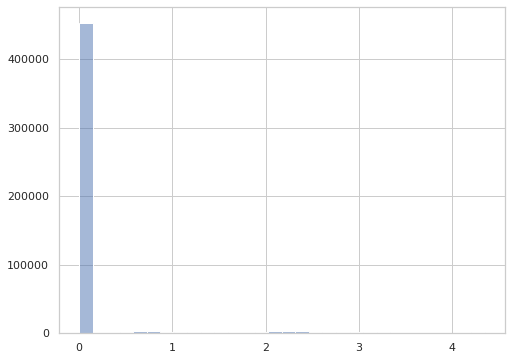

In [19]:
from scipy.stats import skew
# Define a function to plot histogram and check normality
def plot_hist_and_check_normality(old_df, df, cols):
    for col in cols:
        # Plot histogram
        plt.figure(figsize=(8, 6))
        sns.histplot(df[col], bins=30, kde=True)
        plt.title(f'Histogram of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.show()

        # Check normality
        print(f'Normality test for {col}:')
        print('-------------------------------------')
        print('Prev_Skewness:', skew(old_df[col]))
        print('Skewness:', skew(df[col]))
        print('Kurtosis:', df[col].kurtosis())
        print('-------------------------------------\n')

# Call the function with the desired variables
cols_to_plot = ['days_since_request', 'zip_count_4w', 'proposed_credit_limit']
plot_hist_and_check_normality(num_df, new_df, cols_to_plot)

By using logrithm scaling, the normality assessment shows that post-logarithmic scaling reveals a marked improvement in the distribution of the data. The skewness value has decreased substantially from the previous one, suggesting a shift toward a more symmetric distribution.

### Drop Highly Correlated Features

after one-hot encoding our categorical variables, we proceeded to address potential multicollinearity in our dataset. Multicollinearity occurs when two or more variables are highly correlated and can introduce redundancy into our predictive models, possibly distorting the results.

We began by constructing a correlation matrix for num_df using the corr function, which computes the Pearson correlation coefficients between every pair of features. To visualize this matrix, we used Seaborn's heatmap function, applying a mask with np.triu to only display the upper triangle of the symmetrical matrix, improving clarity.

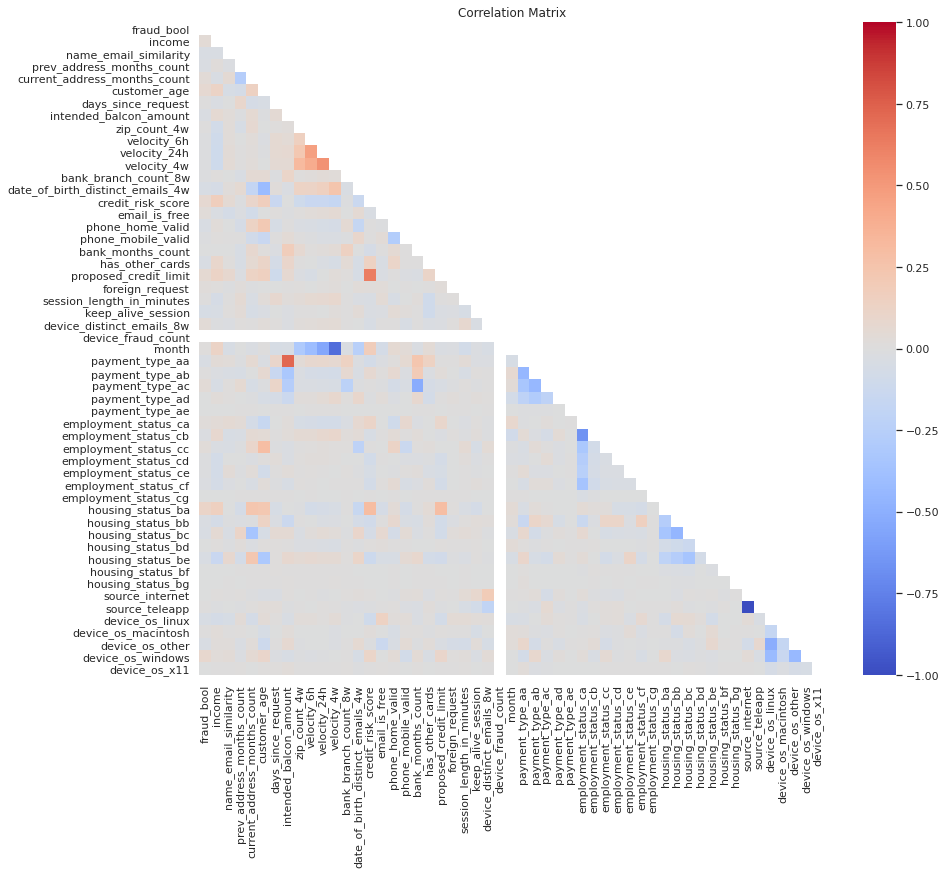

In [20]:
correlation_matrix = new_df.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

From the heatmap, we observed several features with a correlation higher than our threshold of 0.7. To systematically identify these pairs, we implemented a function, group_related_features, which iterates through the absolute values of the correlation matrix to find and group features with correlations exceeding the threshold.

In [21]:
def group_related_features(correlation_matrix, threshold):
    abs_corr_matrix = correlation_matrix.abs()
    related_features = []
    grouped_features = set()

    for feature1 in abs_corr_matrix.columns:
        for feature2 in abs_corr_matrix.columns:
            if feature1 != feature2 and abs_corr_matrix.loc[feature1, feature2] > threshold:
                if (feature2, feature1) not in grouped_features:
                    related_features.append((feature1, feature2))
                    grouped_features.add((feature1, feature2))

    return related_features

threshold = 0.7

# Get the related features as grouped pairs
related_features = group_related_features(correlation_matrix, threshold)
print(related_features)

[('intended_balcon_amount', 'payment_type_aa'), ('velocity_4w', 'month'), ('source_internet', 'source_teleapp')]


Upon identifying correlated feature pairs, we decided to drop one feature from each pair to reduce redundancy. Additionally, we removed the device_fraud_count feature after noticing it only contained zeros, which would not contribute meaningful information to our models.

In [22]:
new_df = new_df.drop(columns = ['payment_type_aa', 'velocity_4w', 'source_teleapp', 'device_fraud_count'])

In [23]:
new_df.columns

Index(['fraud_bool', 'income', 'name_email_similarity',
       'prev_address_months_count', 'current_address_months_count',
       'customer_age', 'days_since_request', 'intended_balcon_amount',
       'zip_count_4w', 'velocity_6h', 'velocity_24h', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'credit_risk_score',
       'email_is_free', 'phone_home_valid', 'phone_mobile_valid',
       'bank_months_count', 'has_other_cards', 'proposed_credit_limit',
       'foreign_request', 'session_length_in_minutes', 'keep_alive_session',
       'device_distinct_emails_8w', 'month', 'payment_type_ab',
       'payment_type_ac', 'payment_type_ad', 'payment_type_ae',
       'employment_status_ca', 'employment_status_cb', 'employment_status_cc',
       'employment_status_cd', 'employment_status_ce', 'employment_status_cf',
       'employment_status_cg', 'housing_status_ba', 'housing_status_bb',
       'housing_status_bc', 'housing_status_bd', 'housing_status_be',
       'housing_sta

By eliminating these highly correlated and non-informative features, we aim to enhance the predictive power of our models and ensure that the effects of each independent variable are isolated and interpretable.

### Identify Feature Importance

In [ ]:
corr = new_df.corr()
target_corr = corr['fraud_bool'].abs().sort_values(ascending=False)
target_corr

In [ ]:
corr = new_df.corr()
target_corr = corr['fraud_bool'].abs().sort_values(ascending=False)
strong_corr_features = target_corr.index[1:11] 

print('Top 10 features with highest correlation with target:')
for feature in strong_corr_features:
    print(f"{feature}: {target_corr[feature]}")

In [ ]:
features = [
    "housing_status_ba",
    "device_os_windows",
    "credit_risk_score",
    "customer_age",
    "proposed_credit_limit",
    "keep_alive_session",
    "income",
    "date_of_birth_distinct_emails_4w",
    "device_os_linux",
    "housing_status_bc",
]

plt.figure(figsize=(12,8))
ax = abs(new_df[features].corrwith(new_df.fraud_bool)).sort_values(ascending=False).plot(kind='bar',color='SteelBlue',fontsize=18)
for p in ax.patches:
    height = p.get_height().round(4)
    ax.text(p.get_x() + p.get_width() / 2., height+0.007, height, ha = 'center', size = 15)
sns.despine()

It is evident that certain features demonstrate a stronger correlation with the fraud_bool target variable. This implies that these features might have a more significant role in predicting fraudulent bank account applications.<br>
Particularly, "housing_status_BA" and "device_os_windows" show a relatively higher correlation with the target variable. These insights suggest that there may be specific patterns within these features that are associated with fraudulent activity.<br>
For housing_status_BA, it could indicate that the housing status provided by the applicant may contain specific trends or anomalies that correlate with fraudulent behavior. It is advisable to further investigate the nature of these correlations. For instance, applicants from certain housing statuses might be more likely to submit fraudulent applications.<br>
Similarly, device_os_windows indicating a strong correlation suggests that the operating system of the device used for the application might be a factor in fraud. It could imply that applications made from devices with Windows OS have different fraud patterns compared to other operating systems. It is crucial to delve deeper into this feature to understand if there is a particular vulnerability or pattern associated with Windows OS that could be exploited for fraudulent purposes.<br>

### Imbalanced Data

Total Number Of Transactions And Basic Distribution

In [24]:
colors = ['Navy', 'LightBlue']
labels = ['Non-Fraud', 'Fraud']
fraud_proportion = new_df['fraud_bool'].value_counts() / new_df['fraud_bool'].shape[0]

fig = go.Figure(data=[go.Pie(labels=labels,
                             values=fraud_proportion)])
fig.update_traces(hoverinfo='label+percent', textinfo='percent', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='black', width=0.1)))
fig.update_layout(
    title_text='<b>Credit Card Fraud</b>',
    legend_title='<b>Transaction Type</b>'
)
fig.show()

In [25]:
normal_num = df[df['fraud_bool'] == 0].shape[0]
fraudulent_num = df[df['fraud_bool'] == 1].shape[0]
print(f"Number of non-fraudulent transactions: {normal_num:,}")
print(f"Number of fraudulent transactions: {fraudulent_num:,}")

Number of non-fraudulent transactions: 988,971
Number of fraudulent transactions: 11,029


#### Observation:<br>
The Credit Card Fraud dataset illustrate a pronounced class imbalance, with a explicit contrast in the occurrence of non-fraudulent account applications (988,971) compared to fraudulent account applications (11,029). This significant discrepancy in distribution poses a challenge for predictive modeling, as it can bias the model towards the majority class, leading to poor generalization on the minority class. To address this issue and improve the performance of models, especially in identifying fraudulent account applicatins, our plan is to employ oversampling techniques. Oversampling aims to balance the dataset by increasing the representation of the minority class (in this case, fraudulent account applications) to a level comparable to the majority class. This approach will help in constructing a more balanced dataset, crucial for training a predictive model that is effectively sensitive to both classes and can accurately identify fraudulent activities.

### oversampling

Oversampling in machine learning boosts the representation of minority classes, balancing model bias and enhancing predictions for these groups.

In [26]:
smote = SMOTE(random_state=42)

X = new_df.drop(columns = ['fraud_bool'])
y = new_df['fraud_bool']

X_resampled, y_resampled = smote.fit_resample(X, y)

resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
resampled_df['fraud_bool'] = y_resampled

In [27]:
resampled_df.shape

(988996, 49)

In [28]:
colors = ['Navy', 'LightBlue']
labels = ['Non-Fraud', 'Fraud']
fraud_proportion = resampled_df['fraud_bool'].value_counts() / resampled_df['fraud_bool'].shape[0]

fig = go.Figure(data=[go.Pie(labels=labels,
                             values=fraud_proportion)])
fig.update_traces(hoverinfo='label+percent', textinfo='percent', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='black', width=0.1)))
fig.update_layout(
    title_text='<b>Credit Card Fraud</b>',
    legend_title='<b>Transaction Type</b>'
)
fig.show()

## Baseline Model

### Description

First, a train-test split:

In [29]:
X = resampled_df.drop(columns = ['fraud_bool'])
y = resampled_df['fraud_bool']

X_train, X_test, y_train, y_test = (
    train_test_split(X, y, random_state=1)
)

Baseline involves features: income, proposed_credit_limit, zip_count_4w, days_since_request<br>
Model selections: Logistics Regression, Decision Tree, Gradient Boosting Machines(GBM), Catboost<br>
**Logistic Regression** is a fundamental classification algorithm that predicts the probability of a binary outcome based on one or more independent variables. It models the relationship between the features and the probability of the target variable being in a specific class. This simplicity makes it highly interpretable, less prone to overfitting with proper regularization, and a solid baseline for evaluating more complex models. It is also particularly effective for binary classification problems, which should work well on predicting fraud_bool.<br>
**Decision Tree** is a versatile supervised learning algorithm that can be used for both classification and regression tasks. It works by splitting the data into subsets based on the value of input features, making it easy to understand and interpret. Decision Trees can capture non-linear relationships between features and the target variable by dividing the space into smaller subsets. <br>
**Gradient Boosting Machines (GBM)** is a powerful ensemble learning technique that builds models in a stage-wise fashion. It involves sequentially adding predictors, focusing on correcting its predecessors' errors using gradient descent. GBM is capable of capturing complex non-linear relationships by combining simple models into a composite model. This approach makes GBM highly effective for a wide range of tasks, including both classification and regression.<br>
**CatBoost** is also based on Gradient Boosting like GBM, it ensembles multiple decision trees and uses gradient boosting to minimize prediction error. It is designed to provide a balance between speed and accuracy, making it highly effective for large datasets and complex problems where categorical data plays a significant role.

### Logistic Regression

In [39]:
# Feature selection
features = ['income', 'proposed_credit_limit', 'zip_count_4w', 'days_since_request']
X_train_features = X_train[features]
X_test_features = X_test[features]

# Initialize the model
lr = LogisticRegression(random_state=1, max_iter=1000)
lr.fit(X_train_features, y_train)

# Predictions
y_pred = lr.predict(X_test_features)
y_pred_proba = lr.predict_proba(X_test_features)[:, 1]

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

lr_metrics = pd.DataFrame({
    'Set': 'LogisticRegression',
    'accuracy': [accuracy],
    'precision': [precision],
    'recall': [recall],
    'f1': [f1],
    'roc_auc': [roc_auc],
})

accuracy, precision, recall, f1, roc_auc

(0.6488196109994379,
 0.6547149997899777,
 0.6302178518865941,
 0.6422329076997243,
 0.6924745359911069)

### Decision Tree 

In [44]:
# Initialize the model
dt_model = DecisionTreeClassifier(random_state=1)
dt_model.fit(X_train_features, y_train)

# Predictions
y_pred_test_dt = dt_model.predict(X_test_features)

# Evaluation
accuracy_dt = accuracy_score(y_test, y_pred_test_dt)
precision_dt = precision_score(y_test, y_pred_test_dt)
recall_dt = recall_score(y_test, y_pred_test_dt)
f1_dt = f1_score(y_test, y_pred_test_dt)
roc_auc_dt = roc_auc_score(y_test, dt_model.predict_proba(X_test_features)[:, 1])

dt_metrics = pd.DataFrame({
    'Set': 'DecisionTree',
    'accuracy': [accuracy_dt],
    'precision': [precision_dt],
    'recall': [recall_dt],
    'f1': [f1_dt],
    'roc_auc': [roc_auc_dt],
})
cm_model_dt = confusion_matrix(y_test, y_pred_test_dt)

accuracy_dt, precision_dt, recall_dt, f1_dt, roc_auc_dt

(0.9484568188344543,
 0.9475820770248894,
 0.9494670957933723,
 0.9485236498768025,
 0.9484565122861445)

### GBM

In [45]:
# Initialize the model
gbm_model = GradientBoostingClassifier(random_state=1)
gbm_model.fit(X_train_features, y_train)

# Predictions
y_pred_test_gbm = gbm_model.predict(X_test_features)

# Evaluation
accuracy_gbm = accuracy_score(y_test, y_pred_test_gbm)
precision_gbm = precision_score(y_test, y_pred_test_gbm)
recall_gbm = recall_score(y_test, y_pred_test_gbm)
f1_gbm = f1_score(y_test, y_pred_test_gbm)
roc_auc_gbm = roc_auc_score(y_test, gbm_model.predict_proba(X_test_features)[:, 1])

gbm_metrics = pd.DataFrame({
    'Set': 'GradientBoosting',
    'accuracy': [accuracy_gbm],
    'precision': [precision_gbm],
    'recall': [recall_gbm],
    'f1': [f1_gbm],
    'roc_auc': [roc_auc_gbm],
})
cm_model_gbm = confusion_matrix(y_test, y_pred_test_gbm)

accuracy_gbm, precision_gbm, recall_gbm, f1_gbm, roc_auc_gbm

(0.9547460252619828,
 0.9925896728419393,
 0.9163607252025683,
 0.9529531970718211,
 0.9830551159287131)

### Catboost

In [46]:
# Initialize the model
catboost_model = CatBoostClassifier(random_state=1, verbose=False)
catboost_model.fit(X_train_features, y_train)

# Predictions
y_pred_test_catboost = catboost_model.predict(X_test_features)

# Evaluation
accuracy_catboost = accuracy_score(y_test, y_pred_test_catboost)
precision_catboost = precision_score(y_test, y_pred_test_catboost)
recall_catboost = recall_score(y_test, y_pred_test_catboost)
f1_catboost = f1_score(y_test, y_pred_test_catboost)
roc_auc_catboost = roc_auc_score(y_test, catboost_model.predict_proba(X_test_features)[:, 1])

cat_metrics = pd.DataFrame({
    'Set': 'CatBoost',
    'accuracy': [accuracy_catboost],
    'precision': [precision_catboost],
    'recall': [recall_catboost],
    'f1': [f1_catboost],
    'roc_auc': [roc_auc_catboost],
})
cm_model_cat = confusion_matrix(y_test, y_pred_test_catboost)

accuracy_catboost, precision_catboost, recall_catboost, f1_catboost, roc_auc_catboost

(0.9598461470016056,
 0.9903680325607064,
 0.9287493328589219,
 0.9585694612527647,
 0.9883590274180022)

In [47]:
combined_metrics = pd.concat([lr_metrics, dt_metrics, gbm_metrics, cat_metrics], ignore_index=True).set_index('Set')
combined_metrics

accuracy  precision    recall        f1   roc_auc
Set                                                                  
LogisticRegression  0.648820   0.654715  0.630218  0.642233  0.692475
DecisionTree        0.948457   0.947582  0.949467  0.948524  0.948457
GradientBoosting    0.954746   0.992590  0.916361  0.952953  0.983055
CatBoost            0.959846   0.990368  0.928749  0.958569  0.988359

Baseline models are trained on the same training set of the same features and the performance is evaluated using AUC(Area Under Receiver Operating Characteristic Curve) for predicting the same set of test data.<br>
**Baseline result** Decision Tree, GBM, and Catboost (average AUC > 0.94) perform significantly better than Logistics Regression (average AUC <0.7) on the same testing set. Among the three advanced models, Catboost and GBM (average AUC > 0.98) performed slightly better than Decision Tree (average AUC < 0.95). Besides, GBM performs much slower than Catboost, which means Catboost can be trained more efficiently.

Text(0.5, 1.0, 'Confusion Matrix of Catboost')

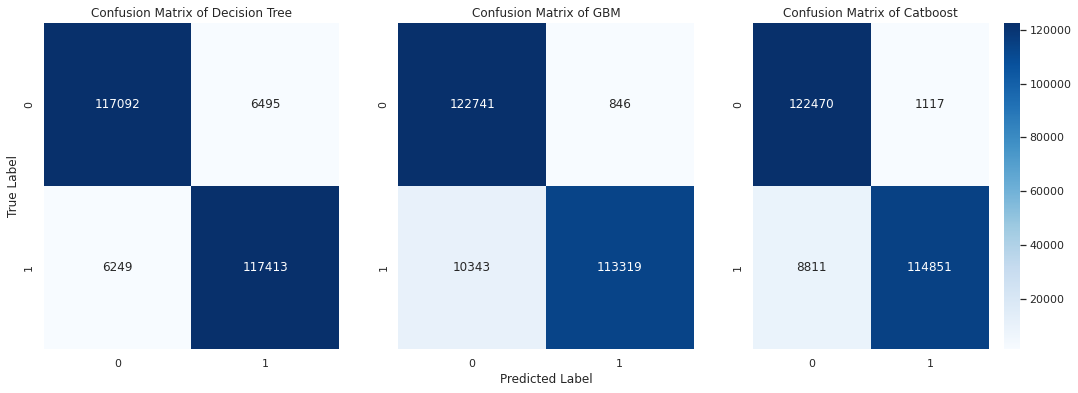

In [60]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

sns.heatmap(cm_model_dt, annot=True, cmap='Blues', fmt='g', ax=axs[0], cbar=False)
axs[0].set_title('Confusion Matrix of Decision Tree')
axs[0].set_ylabel('True Label')

# Plot the second confusion matrix
sns.heatmap(cm_model_gbm, annot=True, cmap='Blues', fmt='g', ax=axs[1], cbar=False)
axs[1].set_title('Confusion Matrix of GBM')
axs[1].set_xlabel('Predicted Label')

# Plot the third confusion matrix
sns.heatmap(cm_model_cat, annot=True, cmap='Blues', fmt='g', ax=axs[2])
axs[2].set_title('Confusion Matrix of Catboost')

The data presented in the confusion matrix offers a comprehensive breakdown of the model's predictions, facilitating a thorough evaluation of its effectiveness. To enhance detection of fraudulent activities, our aim is to increase the instances correctly identified as true positives (true = 1, predicted = 1). At the same time, we seek to reduce the occurrences of false negatives, where true = 1 but predicted = 0, which incorrectly label fraudulent applications as normal. Upon analysis, we may note that both the Decision Tree and Catboost models exhibited slightly better performance compared to GBM in this context.

## Final Model

Model Choosing

Feature Selection

based on the features from baseline model and importance feature ranking

"proposed_credit_limit", "zip_count_4w", "days_since_request" has been log scaling before

In [70]:
final_features = ["income", "proposed_credit_limit", "zip_count_4w", "days_since_request",
                  "credit_risk_score", "customer_age", "keep_alive_session", "date_of_birth_distinct_emails_4w",
                  "housing_status_ba", "device_os_windows", "device_os_linux", "housing_status_bc"]

preproc_final = ColumnTransformer(
    transformers=[
        ('sqrt_n_ingre', FunctionTransformer(np.sqrt), ['n_ingredients']),
        ('calories', Binarizer(threshold=301), ['calories']),
        ('categorical_sentiment', OneHotEncoder(), ['sentiment']),
        ('quantile_avg_rating', QuantileTransformer(output_distribution='uniform'), ['avg_rating']),
        ('standardize_nutrition', StandardScaler(), ['saturated fat', 'protein', 'carbohydrates']),
        ('standardize_cols', StandardScaler(), ['n_ingredients', 'calories']),
    ],
    remainder='passthrough'
)

In [71]:
X_train_features_final = X_train[final_features]
X_test_features_final = X_test[final_features]

In [81]:
# Initialize the model
dt_final = DecisionTreeClassifier(random_state=1)
dt_final.fit(X_train_features_final, y_train)

# training set
y_pred_tra_dt_final = dt_final.predict(X_train_features_final)
acc_dt_tra_final = accuracy_score(y_train, y_pred_tra_dt_final)
pr_dt_tra_final = precision_score(y_train, y_pred_tra_dt_final)
re_dt_tra_final = recall_score(y_train, y_pred_tra_dt_final)
f1_dt_tra_final = f1_score(y_train, y_pred_tra_dt_final)
roc_auc_dt_tra_final = roc_auc_score(y_train, dt_final.predict_proba(X_train_features_final)[:, 1])

# testing set
y_pred_test_dt_final = dt_final.predict(X_test_features_final)
accuracy_dt_final = accuracy_score(y_test, y_pred_test_dt_final)
precision_dt_final = precision_score(y_test, y_pred_test_dt_final)
recall_dt_final = recall_score(y_test, y_pred_test_dt_final)
f1_dt_final = f1_score(y_test, y_pred_test_dt_final)
roc_auc_dt_final = roc_auc_score(y_test, dt_final.predict_proba(X_test_features_final)[:, 1])

dt_metrics_final = pd.DataFrame({
    'Set': ['DecisionTreeTrain', 'DecisionTreeTest'],
    'accuracy': [acc_dt_tra_final, accuracy_dt_final],
    'precision': [pr_dt_tra_final, precision_dt_final],
    'recall': [re_dt_tra_final, recall_dt_final],
    'f1': [f1_dt_tra_final, f1_dt_final],
    'roc_auc': [roc_auc_dt_tra_final, roc_auc_dt_final]
})
cm_model_dt_final = confusion_matrix(y_test, y_pred_test_dt_final)

accuracy_dt_final, precision_dt_final, recall_dt_final, f1_dt_final, roc_auc_dt_final

(0.9785964756176971,
 0.9757636655948553,
 0.9815869062444404,
 0.978666623666664,
 0.9785955682314146)

In [85]:
# Initialize the model
cat_final = CatBoostClassifier(random_state=1)
cat_final.fit(X_train_features_final, y_train)

# training set
y_pred_tra_cat_final = cat_final.predict(X_train_features_final)
acc_tra_cat_final = accuracy_score(y_train, y_pred_tra_cat_final)
pr_tra_cat_final = precision_score(y_train, y_pred_tra_cat_final)
re_tra_cat_final = recall_score(y_train, y_pred_tra_cat_final)
f1_tra_cat_final = f1_score(y_train, y_pred_tra_cat_final)
roc_auc_cat_tra_final = roc_auc_score(y_train, cat_final.predict_proba(X_train_features_final)[:, 1])

# testing set
y_pred_test_cat_final = cat_final.predict(X_test_features_final)
accuracy_cat_final = accuracy_score(y_test, y_pred_test_cat_final)
precision_cat_final = precision_score(y_test, y_pred_test_cat_final)
recall_cat_final = recall_score(y_test, y_pred_test_cat_final)
f1_cat_final = f1_score(y_test, y_pred_test_cat_final)
roc_auc_cat_final = roc_auc_score(y_test, cat_final.predict_proba(X_test_features_final)[:, 1])

cat_metrics_final = pd.DataFrame({
    'Set': ['CatBoostTrain', 'CatBoostTest'],
    'accuracy': [acc_tra_cat_final, accuracy_cat_final],
    'precision': [pr_tra_cat_final, precision_cat_final],
    'recall': [re_tra_cat_final, recall_cat_final],
    'f1': [f1_tra_cat_final, f1_cat_final],
    'roc_auc': [roc_auc_cat_tra_final, roc_auc_cat_final],
})
cm_model_cat_final = confusion_matrix(y_test, y_pred_test_cat_final)

accuracy_cat_final, precision_cat_final, recall_cat_final, f1_cat_final, roc_auc_cat_final

Learning rate set to 0.173194
0:	learn: 0.5341761	total: 168ms	remaining: 2m 47s
1:	learn: 0.4296034	total: 328ms	remaining: 2m 43s
2:	learn: 0.3522189	total: 446ms	remaining: 2m 28s
3:	learn: 0.3010187	total: 594ms	remaining: 2m 27s
4:	learn: 0.2675845	total: 741ms	remaining: 2m 27s
5:	learn: 0.2444152	total: 868ms	remaining: 2m 23s
6:	learn: 0.2259938	total: 1s	remaining: 2m 22s
7:	learn: 0.2129992	total: 1.12s	remaining: 2m 19s
8:	learn: 0.1943102	total: 1.27s	remaining: 2m 20s
9:	learn: 0.1620297	total: 1.45s	remaining: 2m 23s
10:	learn: 0.1531943	total: 1.58s	remaining: 2m 22s
11:	learn: 0.1487067	total: 1.7s	remaining: 2m 20s
12:	learn: 0.1330988	total: 1.86s	remaining: 2m 21s
13:	learn: 0.1257135	total: 2.01s	remaining: 2m 21s
14:	learn: 0.1198201	total: 2.15s	remaining: 2m 21s
15:	learn: 0.1151289	total: 2.27s	remaining: 2m 19s
16:	learn: 0.1107708	total: 2.39s	remaining: 2m 18s
17:	learn: 0.1055527	total: 2.5s	remaining: 2m 16s
18:	learn: 0.1038528	total: 2.6s	remaining: 2m 14

159:	learn: 0.0511496	total: 19.5s	remaining: 1m 42s
160:	learn: 0.0510196	total: 19.6s	remaining: 1m 42s
161:	learn: 0.0509449	total: 19.7s	remaining: 1m 41s
162:	learn: 0.0509229	total: 19.8s	remaining: 1m 41s
163:	learn: 0.0508983	total: 19.9s	remaining: 1m 41s
164:	learn: 0.0508496	total: 20.1s	remaining: 1m 41s
165:	learn: 0.0508164	total: 20.2s	remaining: 1m 41s
166:	learn: 0.0506483	total: 20.3s	remaining: 1m 41s
167:	learn: 0.0506187	total: 20.5s	remaining: 1m 41s
168:	learn: 0.0505814	total: 20.6s	remaining: 1m 41s
169:	learn: 0.0505532	total: 20.7s	remaining: 1m 41s
170:	learn: 0.0505121	total: 20.8s	remaining: 1m 41s
171:	learn: 0.0504497	total: 21s	remaining: 1m 40s
172:	learn: 0.0504145	total: 21.1s	remaining: 1m 40s
173:	learn: 0.0503948	total: 21.2s	remaining: 1m 40s
174:	learn: 0.0503793	total: 21.3s	remaining: 1m 40s
175:	learn: 0.0503366	total: 21.4s	remaining: 1m 40s
176:	learn: 0.0503222	total: 21.5s	remaining: 1m 39s
177:	learn: 0.0502813	total: 21.6s	remaining: 1m

315:	learn: 0.0465288	total: 36.2s	remaining: 1m 18s
316:	learn: 0.0465190	total: 36.3s	remaining: 1m 18s
317:	learn: 0.0464827	total: 36.4s	remaining: 1m 18s
318:	learn: 0.0464596	total: 36.5s	remaining: 1m 17s
319:	learn: 0.0464273	total: 36.6s	remaining: 1m 17s
320:	learn: 0.0464019	total: 36.7s	remaining: 1m 17s
321:	learn: 0.0463829	total: 36.8s	remaining: 1m 17s
322:	learn: 0.0463500	total: 36.9s	remaining: 1m 17s
323:	learn: 0.0463301	total: 37s	remaining: 1m 17s
324:	learn: 0.0462885	total: 37.1s	remaining: 1m 17s
325:	learn: 0.0462695	total: 37.2s	remaining: 1m 16s
326:	learn: 0.0462461	total: 37.3s	remaining: 1m 16s
327:	learn: 0.0462405	total: 37.4s	remaining: 1m 16s
328:	learn: 0.0462276	total: 37.4s	remaining: 1m 16s
329:	learn: 0.0462170	total: 37.6s	remaining: 1m 16s
330:	learn: 0.0462047	total: 37.7s	remaining: 1m 16s
331:	learn: 0.0461781	total: 37.8s	remaining: 1m 16s
332:	learn: 0.0461663	total: 37.9s	remaining: 1m 15s
333:	learn: 0.0461500	total: 38.1s	remaining: 1m

474:	learn: 0.0434352	total: 53.1s	remaining: 58.7s
475:	learn: 0.0434213	total: 53.2s	remaining: 58.6s
476:	learn: 0.0434043	total: 53.3s	remaining: 58.5s
477:	learn: 0.0433821	total: 53.5s	remaining: 58.4s
478:	learn: 0.0433664	total: 53.6s	remaining: 58.3s
479:	learn: 0.0433499	total: 53.8s	remaining: 58.2s
480:	learn: 0.0433350	total: 53.9s	remaining: 58.1s
481:	learn: 0.0433263	total: 54s	remaining: 58s
482:	learn: 0.0433200	total: 54.1s	remaining: 57.9s
483:	learn: 0.0432977	total: 54.2s	remaining: 57.8s
484:	learn: 0.0432834	total: 54.3s	remaining: 57.7s
485:	learn: 0.0432751	total: 54.5s	remaining: 57.6s
486:	learn: 0.0432568	total: 54.6s	remaining: 57.5s
487:	learn: 0.0432355	total: 54.7s	remaining: 57.4s
488:	learn: 0.0432228	total: 54.8s	remaining: 57.3s
489:	learn: 0.0432051	total: 54.9s	remaining: 57.2s
490:	learn: 0.0431912	total: 55s	remaining: 57s
491:	learn: 0.0431785	total: 55.2s	remaining: 57s
492:	learn: 0.0431632	total: 55.3s	remaining: 56.9s
493:	learn: 0.0431454	

633:	learn: 0.0416738	total: 1m 11s	remaining: 41.4s
634:	learn: 0.0416635	total: 1m 11s	remaining: 41.3s
635:	learn: 0.0416522	total: 1m 11s	remaining: 41.2s
636:	learn: 0.0416352	total: 1m 12s	remaining: 41.1s
637:	learn: 0.0416165	total: 1m 12s	remaining: 41s
638:	learn: 0.0415993	total: 1m 12s	remaining: 40.9s
639:	learn: 0.0415956	total: 1m 12s	remaining: 40.7s
640:	learn: 0.0415807	total: 1m 12s	remaining: 40.6s
641:	learn: 0.0415755	total: 1m 12s	remaining: 40.5s
642:	learn: 0.0415667	total: 1m 12s	remaining: 40.4s
643:	learn: 0.0415517	total: 1m 12s	remaining: 40.3s
644:	learn: 0.0415450	total: 1m 12s	remaining: 40.2s
645:	learn: 0.0415364	total: 1m 13s	remaining: 40s
646:	learn: 0.0415364	total: 1m 13s	remaining: 39.9s
647:	learn: 0.0415298	total: 1m 13s	remaining: 39.8s
648:	learn: 0.0415138	total: 1m 13s	remaining: 39.7s
649:	learn: 0.0415137	total: 1m 13s	remaining: 39.5s
650:	learn: 0.0415137	total: 1m 13s	remaining: 39.4s
651:	learn: 0.0415137	total: 1m 13s	remaining: 39.

789:	learn: 0.0406821	total: 1m 27s	remaining: 23.2s
790:	learn: 0.0406821	total: 1m 27s	remaining: 23.1s
791:	learn: 0.0406821	total: 1m 27s	remaining: 22.9s
792:	learn: 0.0406744	total: 1m 27s	remaining: 22.8s
793:	learn: 0.0406743	total: 1m 27s	remaining: 22.7s
794:	learn: 0.0406743	total: 1m 27s	remaining: 22.6s
795:	learn: 0.0406743	total: 1m 27s	remaining: 22.5s
796:	learn: 0.0406743	total: 1m 27s	remaining: 22.4s
797:	learn: 0.0406743	total: 1m 27s	remaining: 22.2s
798:	learn: 0.0406742	total: 1m 27s	remaining: 22.1s
799:	learn: 0.0406655	total: 1m 28s	remaining: 22s
800:	learn: 0.0406572	total: 1m 28s	remaining: 21.9s
801:	learn: 0.0406318	total: 1m 28s	remaining: 21.8s
802:	learn: 0.0406253	total: 1m 28s	remaining: 21.7s
803:	learn: 0.0406160	total: 1m 28s	remaining: 21.6s
804:	learn: 0.0406057	total: 1m 28s	remaining: 21.5s
805:	learn: 0.0405843	total: 1m 28s	remaining: 21.4s
806:	learn: 0.0405766	total: 1m 28s	remaining: 21.3s
807:	learn: 0.0405674	total: 1m 28s	remaining: 2

946:	learn: 0.0392131	total: 1m 44s	remaining: 5.87s
947:	learn: 0.0392131	total: 1m 44s	remaining: 5.76s
948:	learn: 0.0392049	total: 1m 45s	remaining: 5.64s
949:	learn: 0.0391914	total: 1m 45s	remaining: 5.53s
950:	learn: 0.0391914	total: 1m 45s	remaining: 5.42s
951:	learn: 0.0391913	total: 1m 45s	remaining: 5.31s
952:	learn: 0.0391913	total: 1m 45s	remaining: 5.2s
953:	learn: 0.0391912	total: 1m 45s	remaining: 5.09s
954:	learn: 0.0391905	total: 1m 45s	remaining: 4.98s
955:	learn: 0.0391695	total: 1m 45s	remaining: 4.88s
956:	learn: 0.0391566	total: 1m 46s	remaining: 4.77s
957:	learn: 0.0391520	total: 1m 46s	remaining: 4.66s
958:	learn: 0.0391479	total: 1m 46s	remaining: 4.54s
959:	learn: 0.0391315	total: 1m 46s	remaining: 4.43s
960:	learn: 0.0391231	total: 1m 46s	remaining: 4.33s
961:	learn: 0.0391206	total: 1m 46s	remaining: 4.22s
962:	learn: 0.0391103	total: 1m 46s	remaining: 4.11s
963:	learn: 0.0391070	total: 1m 46s	remaining: 3.99s
964:	learn: 0.0390995	total: 1m 47s	remaining: 

(0.9866612200656019,
 0.9969776045451543,
 0.9762902104122527,
 0.9865254659704688,
 0.9971061207306913)

In [86]:
combined_metrics_final = pd.concat([dt_metrics_final, cat_metrics_final], ignore_index=True).set_index('Set')
combined_metrics_final

accuracy  precision    recall        f1   roc_auc
Set                                                                 
DecisionTreeTrain  1.000000   1.000000  1.000000  1.000000  1.000000
DecisionTreeTest   0.978596   0.975764  0.981587  0.978667  0.978596
CatBoostTrain      0.988012   0.997586  0.978389  0.987894  0.998166
CatBoostTest       0.986661   0.996978  0.976290  0.986525  0.997106

Text(0.5, 30.5, 'Predicted Label')

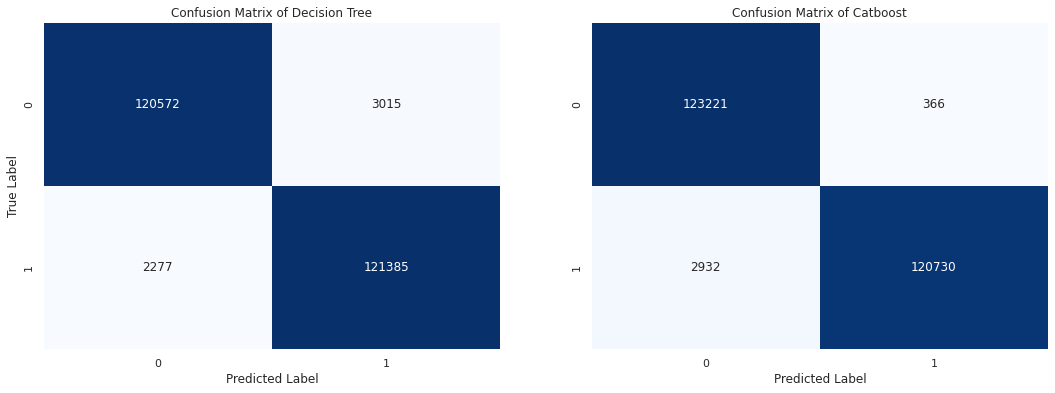

In [77]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

sns.heatmap(cm_model_dt_final, annot=True, cmap='Blues', fmt='g', ax=axs[0], cbar=False)
axs[0].set_title('Confusion Matrix of Decision Tree')
axs[0].set_ylabel('True Label')
axs[0].set_xlabel('Predicted Label')

# Plot the second confusion matrix
sns.heatmap(cm_model_cat_final, annot=True, cmap='Blues', fmt='g', ax=axs[1], cbar=False)
axs[1].set_title('Confusion Matrix of Catboost')
axs[1].set_xlabel('Predicted Label')
